# Setting Parameters for Frangi-based Segmentation

This is the preferred method for images with a lot of false objects, including those of hyphae from environmental samples taken with a microscope. It is a bit more expensive computationally the thresholding based method, and is more sensitive to the parameters chosen. 

Use this script to make decisions about critical parameters based on the images you capture. Base this on 5-10 images that have the characteristics of:
- Similar, representative color profile
- Variety of challenges. For hyphae detection, this includes: dirty areas, hyphae-like objects (skinny, long, but unstained), fat objects, blurry/thin hyphae, etc.

Then, either:
- Update an `frangi_segmentation_analysis.py` script for your image loop. 
- Run `frangi_image_loop()` at the end of this notebook.

The image loop function saves a dataframe to a .CSV with columns:
- Image: Identifier of each image
- NObjects: Number of individual objects measured in Image (without diameter binning)
- Diameter: Mean diameter of all objects in Image(in pixels)
- Length: Total length of all objects in Image (in pixels)
Alternatively, objects can be binned by diameter class. This returns a dataframe specifying length by diameter class, using similarly intuitive column names. 

## Steps
1. Load images and libraries
2. Equalize exposure
3. View candidate colorspace bands
4. Pull the band of interest
5. Enhance vessels with the frangi filter
6. Adaptive threshold to segment frangi filter
7. Filter based on color
8. Filter based on geometry
9. Filter based on hollowness
10. Combine filters and check results
11. Remove small holes and close small gaps
12. Fun another, more stringent geometry filter
13. Skeletonize
14. Summarize
15. Export parameters
16. Test full analysis for stability
17. Run loop

## 1. Load images and libraries

Image: CM1-0039.png
Image Dimensions [length, width, bands]: [1741, 1741, 3]


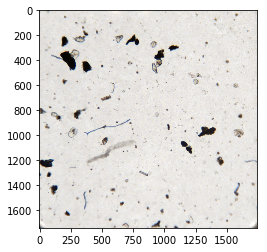

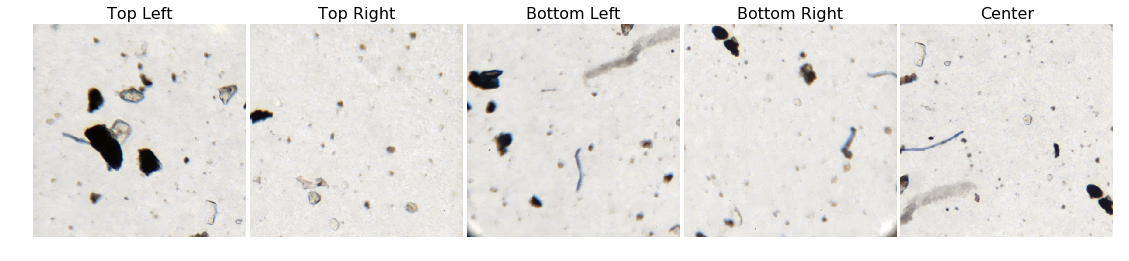

In [1]:
%matplotlib inline

#########################################################################################
dir_in = "/home/patrick/Documents/HLD Pictures Feb 2017/image filtered/C Inputs HLD Images/02-09-2017"
file_in = ["CM1-0039.png", "CM1-0040.png", "CM1-0043.png", "CM1-0044.png", "CM1-0051.png", 
           "CM1-0055.png", "CM1-0067.png", "CM1-0072.png", "CM1-0075.png", "CM1-0076.png"]

# what do you want to work on for the moment? Select the image index from file_in.
selection = 0
zoom_dim = 700

# Zoom to these bounding boxes for easy viewing.
# zoom_topleft =     {'xmin' : 300,
#                     'xmax' : 1000,
#                     'ymin' : 300,
#                     'ymax' : 1000}
# zoom_topright =    {'xmin' : 1000,
#                     'xmax' : 1700,
#                     'ymin' : 0,
#                     'ymax' : 700}
# zoom_bottomleft =  {'xmin' : 0,
#                     'xmax' : 700,
#                     'ymin' : 1000,
#                     'ymax' : 1700}
# zoom_bottomright = {'xmin' : 1040,
#                     'xmax' : 1740,
#                     'ymin' : 1040,
#                     'ymax' : 1740}
# zoom_center=       {'xmin' : 500,
#                     'xmax' : 1200,
#                     'ymin' : 500,
#                     'ymax' : 1200}
plot = True
# plot = False
#########################################################################################

from matplotlib import pyplot as plt
from skimage import io, color, filters, draw, morphology, exposure, img_as_float, img_as_ubyte, restoration, measure
import pyroots as pr
import numpy as np
from scipy import ndimage
import warnings
import pandas as pd
import os

image = io.imread(os.path.join(dir_in, file_in[selection]))

xmax = image.shape[1]
xmin = xmax - zoom_dim
ymax = image.shape[0]
ymin = ymax - zoom_dim

zoom_list = [{'xmin' : 0, 'xmax' : zoom_dim, 'ymin' : 0, 'ymax' : zoom_dim}, 
             {'xmin' : xmin, 'xmax' : xmax, 'ymin' : 0, 'ymax' : zoom_dim},
             {'xmin' : 0, 'xmax' : zoom_dim, 'ymin' : ymin, 'ymax' : ymax},
             {'xmin' : xmin, 'xmax' : xmax, 'ymin' : ymin, 'ymax' : ymax},
             {'xmin' : int(xmin/2), 'xmax' : int((xmax + zoom_dim)/2), 'ymin' : int(ymin/2), 'ymax' : int((ymax + zoom_dim)/2)}
            ]
zoom_names = ['Top Left',
              'Top Right',
              'Bottom Left',
              'Bottom Right',
              'Center'] # length and order should match len(zoom_list)

print("Image: " + file_in[selection] + "\nImage Dimensions [length, width, bands]: " + str([i for i in image.shape]))

if plot is True:
    img = image
    plt.imshow(img)

    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 3. Select the band of the colorspace for identifying candidate objects
Choose a band that shows hyphae clearly and consistently. Some distinction between hyphae and non-hyphae objects helps but is not essential. Objects should not be partly outlined in higher (lighter) values; for this reason, avoid chroma type bands like hue of hsv or a\* and b\* of l\*a\*b\*. For analine blue stain in a microscope, the red band of rgb is good. 

In general, a single band is sufficient for identifying candidate objects.

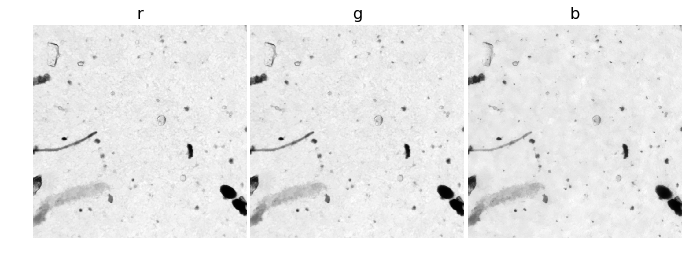

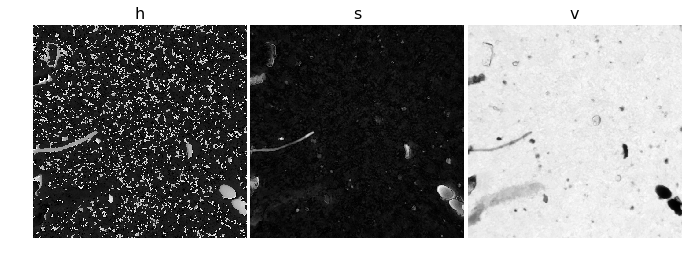

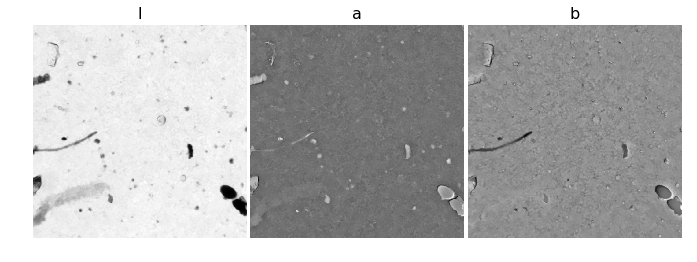

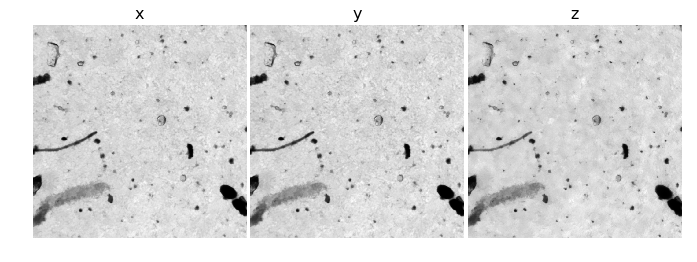

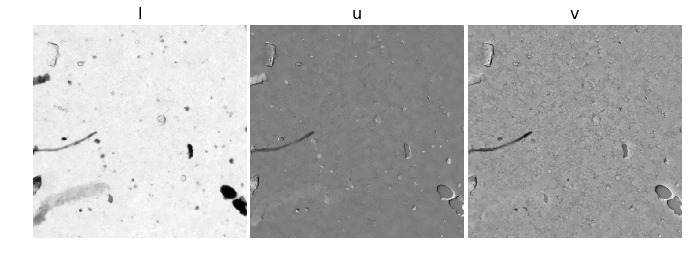

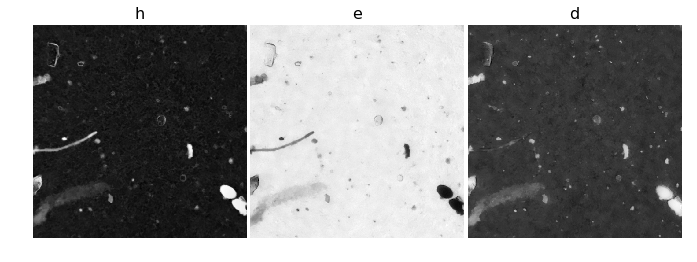

In [4]:
####################################################
colorspaces = ['rgb','hsv','lab','xyz','luv', 'hed'] # add or remove whatever you're curious about. See skimage.color.rgb2*()
colorspace_zoom = zoom_list[4]
####################################################
bandviewer=True
# bandviewer = False
if bandviewer is True: [pr.band_viewer(image, i, colorspace_zoom) for i in colorspaces]

## 4. Pull out the band of interest
Identify the colorspace and band that seems to show objects clearly, while also highlighting differences from non-objects.

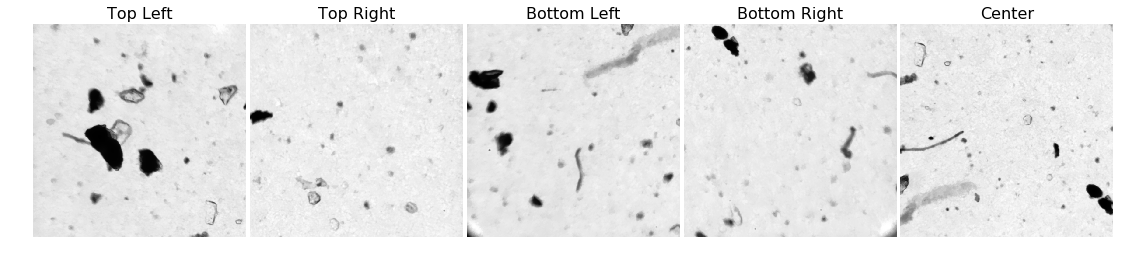

In [4]:
#########################################################################################
colors = {'colorspace' : 'rgb',
          'band'       : 0,      # rgb: 0 = red, 1 = green, 2 = blue
          'dark_on_light'     : False}  # True for light objects on dark background
#########################################################################################

# convert colorspace if necessary
band = pr.band_selector(image, colors)
nbands = len(band)

for j in band:
    img = j
    if plot is True: pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 5. Run frangi filter

The frangi filter enhances ridges/edges of a series of widths and set contrast from neighboring objects. Width is controlled by `sigma`, dictated by `scale_range` and `scale_step`. Sensitivity is controlled by `beta2`. See <a href="http://scikit-image.org/docs/dev/api/skimage.filters.html"> documentation</a>.

Pick a `scale_range` that highlights whole hyphae and edges of larger objects. For hyphae at 100x, a scale range of `(2, 8)` works well. `scale_step` should sufficiently cover width classes. `beta1` should be nearly 1 for best behavior. `beta2` controls the sensitivity, and should be set so that objects are clear, and touching objects have an area of lower response between them. The value probably will be close to 0.05. Expect lots of spurrious, small objects that will be removed with further filtering. 

0.999999995669
0.0


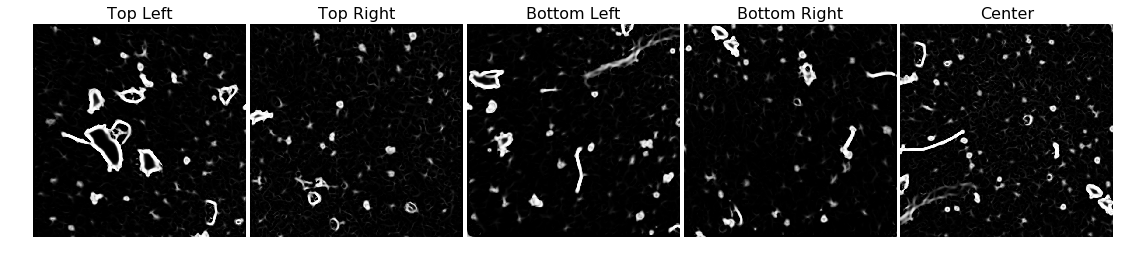

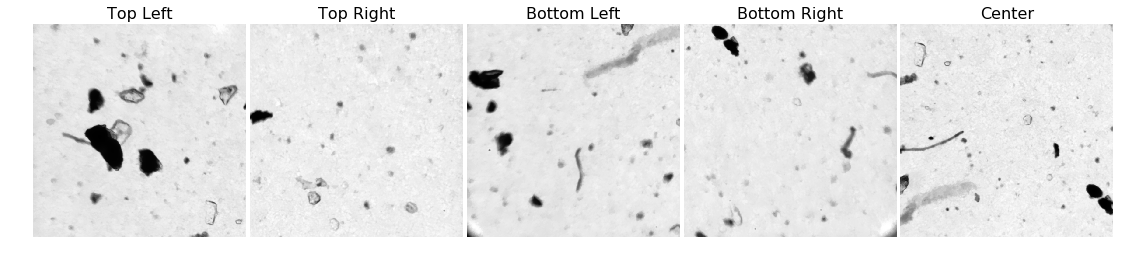

In [6]:
#########################################################################################
frangi_args = {'scale_range'  : (2, 6),  # sigmas for running the filter. Wider enhances wider objects; narrow enhances narrow objects.
               'scale_step'   : 1,       # step between sigmas in the scale range.
               'beta1'        : 0.99,    # correction [0,1] toward linear vs ring-like. Want close to 1.
               'beta2'        : 0.03,    # sensitivity to low-contrast areas. Smaller is more sensitive.
               'black_ridges' : True}    # dark objects on light background? Suggest inverting with colors and holding this True.
#########################################################################################


frangi = filters.frangi(band, **frangi_args)  # detect black or white ridges

if plot is True:
    print(frangi.max())
    print(frangi.min())
    img = frangi
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
    # img = rescaled[0] > np.percentile(rescaled[0], 98)
    img = band
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

##### 6. Adaptive threshold the frangi filter
Now identify objects and edges using an adaptive threshold. The advantage of this is, it separates distinct objects from each other due to their combined high response giving a locally high thresholed. For it to work, the sensitivity of the frangi filter must be low enough to give low responses where objects touch. 

Strategy:
* `block_size` : Defines the local neighborhood for thresholding. Should be small enough to be responsive to the local neighborhood, but large enough to avoid splitting wider objects. For frangi vessel range of [2:8], a `block_size` of 29 is good.
* `offset` : Sets the threshold for the area. Range [0:1] for float images like these. Highly sensitive. The ideal value proably will be between 0.05 and 0.1.

The image shows separate colors for each individual object (via `scipy.ndimage.label`). Use this to evaluate connectivity among objects. See <a href="http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_adaptive"> documentation</a>.

/home/patrick/Programs/scikit-image/skimage/filters/thresholding.py:221: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/home/patrick/Programs/scikit-image/skimage/filters/thresholding.py:223: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


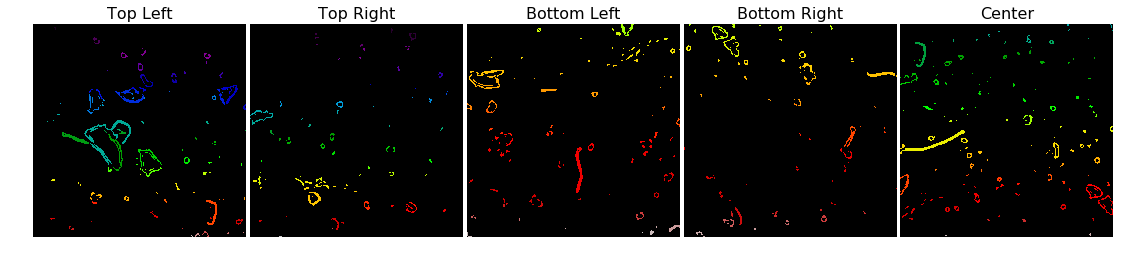

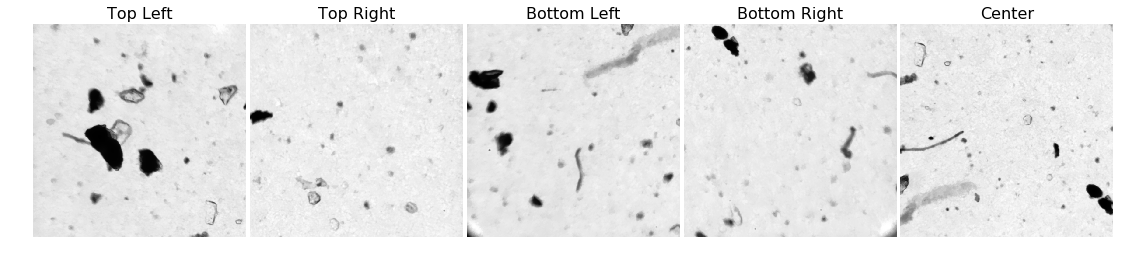

In [7]:
#########################################################################################
threshold_args = {'block_size' : 31,  # small enough to respond strongly to the local neighborhood, large enough to avoid hollowing objects
                  'offset'     : 0.21}  # high enough to separate touching objects, but low enough to maintain connectivity
#########################################################################################

thresh = 1 - (frangi/frangi.max())  # invert, rescale so vessels are dark.
thresh = ~filters.threshold_adaptive(thresh, **threshold_args)  # invert so objects are True

if plot is True:
    img = ndimage.label(thresh)[0]
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map = "spectral")
    img = band
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 7. Filter objects by color values
If staining, objects should be a consistent color if not a consistent saturation. This provides a way of distinguishing real objects from spurrious ones. The algorithm determines whether each pixel of a band array falls within range, then computes the area of those pixels within an object meets a minimum percent of the total area of each object. See <a href="https://github.com/pme1123/pyroots/blob/master/pyroots/noise_filters.py"> documentation</a>. If working with a grayscale image or want to feed the band manually, choose `grayscale_filter` instead of `color_filter`. 

Strategy:
1. Choose a `target_band` from a `colorspace` where real objects and false objects don't overlap too much. For the example image, I chose blue in RGB and saturation in HSV.
2. Determine the `low` and `high` range of values that real objects should take.
3. Set a minimum `percent` of pixels in an object that should be within this value range. 

These thresholds will not be perfect, so set them to give a little wiggle room. We're particularly interested in large objects that are linear, like hyphae. Test for sensitivity. It might be helpful to look at thresholded images where the threshold is set too high (oversegmentation). 

To help set bounds, these code blocks print 0.5%, 50%, and 99.5% values as well as band values with a spectral key. The 50% value should be the background, with lower and higher values denoted by blue and red, respectively. 

### Color Filter 1
Blue in RGB: 
Background has a very high value; true objects have a moderate-high value; dirt and such has a low value. I chose parameters to allow a little wiggle (+/- 0.1 direction for `low`, `high`, +/- 5 `percent`) without changing true objects acceptance. Note that objects that look like hyphae but aren't (long, solid, thin) are the most important to remove. Small, hollow, and rounder objects will be removed later. 

The values I chose for Blue in RGB remove much of the top left false objects, but fail to remove the quarter circle in the top right. They do, however, preserve all true hyphae. Note that you can also select objects that you want to remove, by inverting the color filter. 

/home/patrick/.local/lib/python3.5/site-packages/pyroots/noise_filters.py:97: RuntimeWarning: divide by zero encountered in true_divide
  test = in_range_area/binary_area >= percent/100
/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


99.9: 0.9450980392156862
99.5%: 0.929411764706
50%: 0.882352941176
0.5%: 0.0705882352941

FILTERED OBJECTS


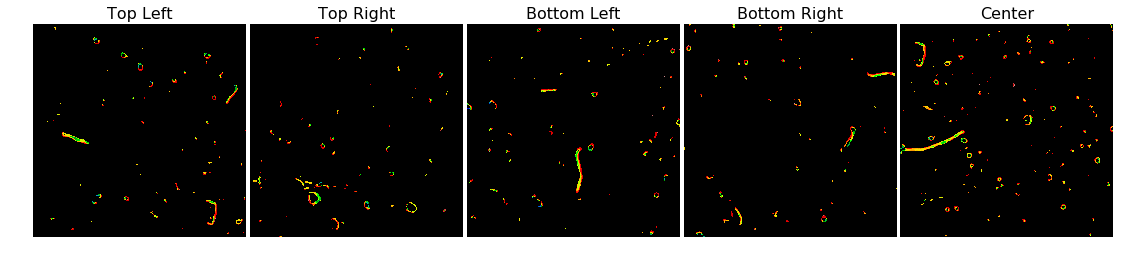

ORIGINAL OBJECTS


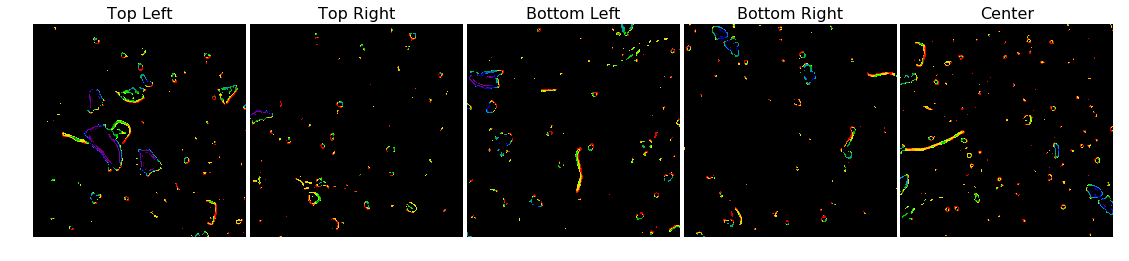

BAND (low is blue; high is red; rescaled for each facet)


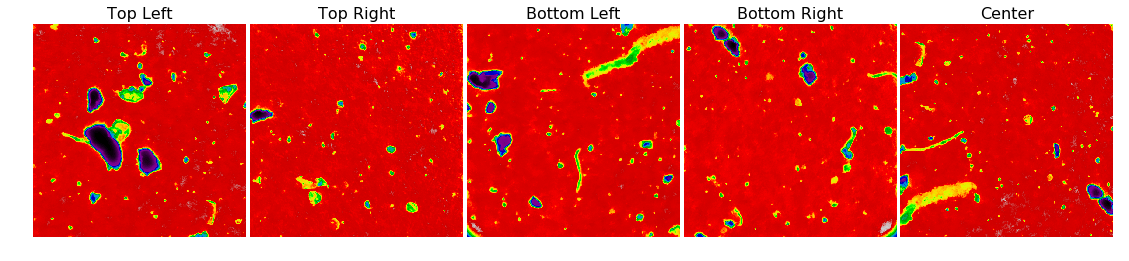

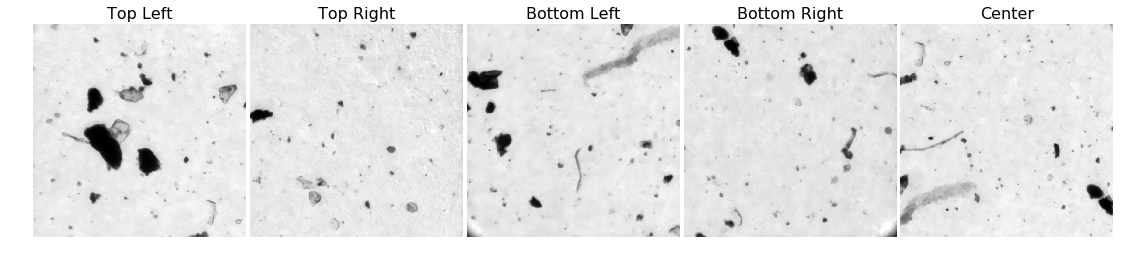

In [8]:
#########################################################################################
color_args_1 = {'colorspace'  : 'rgb',  # Colorspace from which to select band
                'target_band' : 2,      # Band of colorspace
                'low'         : 0.6,    # minimum of range for color value (as float, passes to pyroots._in_range uses)
                'high'        : 0.99,   # maximum of range for color value
                'percent'     : 55,     # minimum percent of all pixels that must fall with the range
                'invert'      : False}  # Are you selecting objects you want to remove?
# color_args_1 = None
colorargs = color_args_1  # update this when you add new bands. Suggest naming sequentially.

# run_on = morph_filt
run_on = thresh
#########################################################################################

# for viewing
try:
    colorband = getattr(color, 'rgb2' + colorargs['colorspace'])(image)
except:
    colorband = image.copy()
    colorband = img_as_float(pr.img_split(colorband)[colorargs['target_band']])

try:
    colorfilt = pr.color_filter(image, run_on, **colorargs)  # image is the original input image
except:
    colorfilt = np.ones(run_on.shape)

####### Update this, as well, for multiple bands
colorfilt1 = colorfilt.copy()  # image is the original input image4

if plot is True:
    if colorargs is not None:
        print("99.9: {}".format(np.percentile(colorband, 99.9)))
        print('99.5%: ' + str(np.percentile(colorband, 99.5)))
        print('50%: ' + str(np.percentile(colorband, 50)))
        print('0.5%: ' + str(np.percentile(colorband, 0.5)))
        print('\nFILTERED OBJECTS')
        temp = colorband.copy()
        temp[~colorfilt] = 0
        img = temp
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
        print('ORIGINAL OBJECTS')
        temp = colorband.copy()
        temp[~thresh] = 0
        img = temp
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
        print('BAND (low is blue; high is red; rescaled for each facet)')
        img = colorband
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="gray")

### Color Filter 2
Saturation in HSV: Background and objects have high values; objects have relatively low values but variability is large.
Based on the previous color filter, choose objects that you want to remove that would be difficult to remove with morphology filtering. Note you can also invert, to 'keep' objects that you want to remove. 

Again, tolerance is +/-5 `percent` and +/- 0.01 `low` and `high`. 

I did lose a small piece of hyphae in the top right; this very faint bit is acceptable.

/home/patrick/.local/lib/python3.5/site-packages/pyroots/noise_filters.py:97: RuntimeWarning: divide by zero encountered in true_divide
  test = in_range_area/binary_area >= percent/100


99.9: 0.9666666666666667
99.5%: 0.949019607843
50%: 0.1
0.5%: 0.0

FILTERED OBJECTS


/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


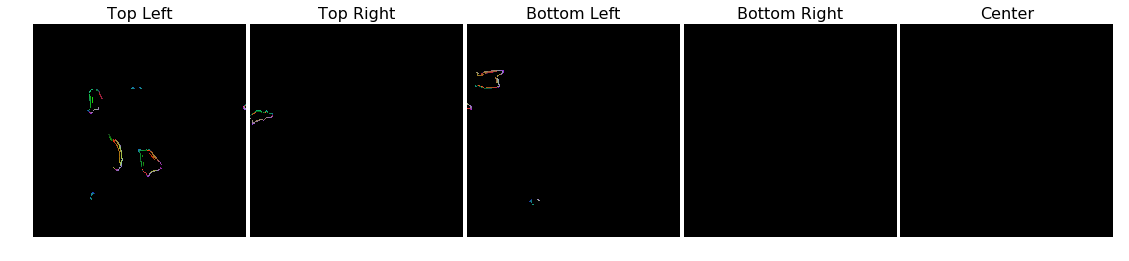

BAND (low is blue; high is red; rescaled for each facet)


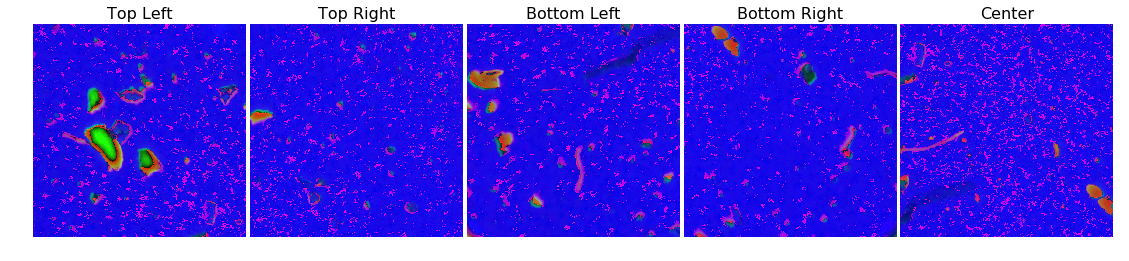

ORIGINAL OBJECTS


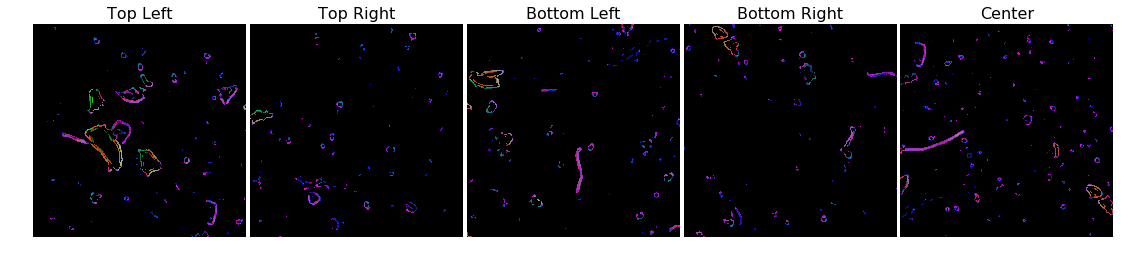

In [9]:
#########################################################################################
color_args_2 = {'colorspace'  : 'hsv',  # Colorspace from which to select band
                'target_band' : 1,      # Band of colorspace
                'low'         : 0.5,    # minimum of range for color value
                'high'        : 1,   # maximum of range for color value
                'percent'     : 30,    # minimum percent of all pixels that must fall with the range
                'invert'      : True}  # selecting objects I don't want to keep. 
# color_args_2 = None

run_on = thresh
# run_on = morph_filt

colorargs = color_args_2  # update this when you add new bands. Suggest naming sequentially.
#########################################################################################

# for viewing
try:
    colorband = getattr(color, 'rgb2' + colorargs['colorspace'])(image)
except:
    colorband = image.copy()
    colorband = img_as_float(pr.img_split(colorband)[colorargs['target_band']])

try:
    colorfilt = pr.color_filter(image, run_on, **colorargs)  # image is the original input image
except:
    colorfilt = np.ones(run_on.shape)

####### Update this, as well, for multiple bands
colorfilt2 = colorfilt.copy()  # image is the original input image4

if plot is True:
    if colorargs is not None:
        print("99.9: {}".format(np.percentile(colorband, 99.9)))
        print('99.5%: ' + str(np.percentile(colorband, 99.5)))
        print('50%: ' + str(np.percentile(colorband, 50)))
        print('0.5%: ' + str(np.percentile(colorband, 0.5)))
        print('\nFILTERED OBJECTS')
        temp = colorband.copy()
        temp[colorfilt] = 0
        img = temp
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
        print('BAND (low is blue; high is red; rescaled for each facet)')
        img = colorband
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
        print('ORIGINAL OBJECTS')
        temp = colorband.copy()
        temp[~thresh] = 0
        img = temp
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")

## Color Filter 3

/home/patrick/.local/lib/python3.5/site-packages/pyroots/noise_filters.py:97: RuntimeWarning: divide by zero encountered in true_divide
  test = in_range_area/binary_area >= percent/100
/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


99.9: 0.9666666666666669
99.5%: 0.944444444444
50%: 0.1
0.5%: 0.0

FILTERED OBJECTS


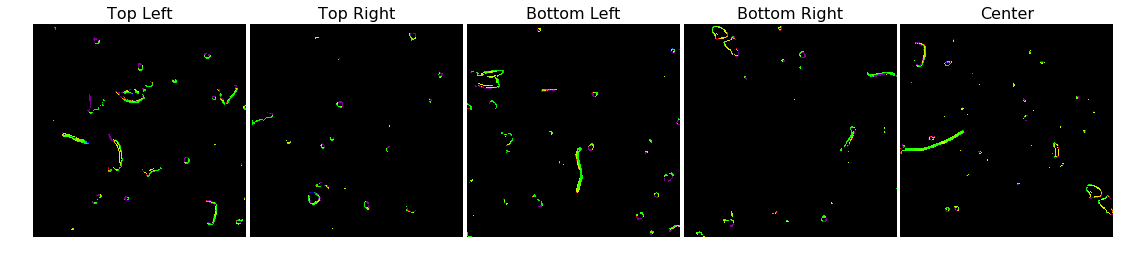

BAND (low is blue; high is red; rescaled for each facet)


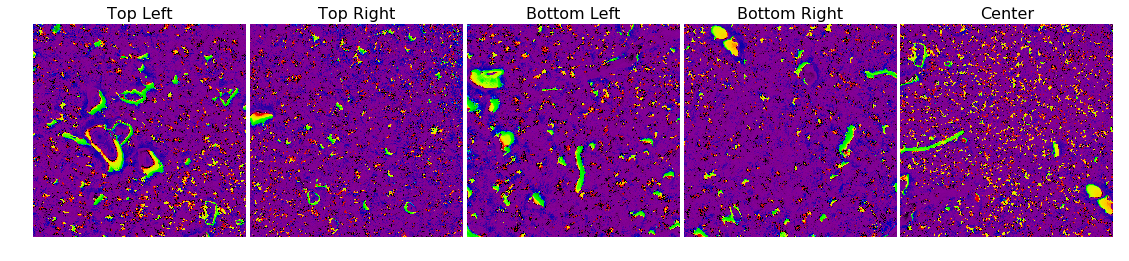

ORIGINAL OBJECTS


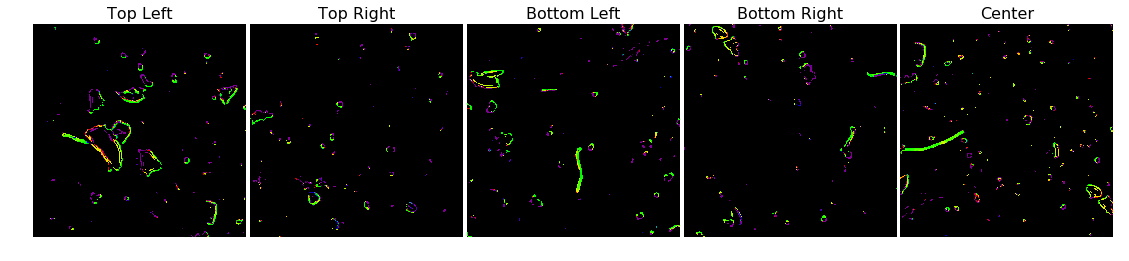

In [10]:
#########################################################################################
color_args_3 = {'colorspace'  : 'hsv',  # Colorspace from which to select band
                'target_band' : 0,      # Band of colorspace
                'low'         : 0.450,    # minimum of range for color value
                'high'        : 0.69,   # maximum of range for color value
                'percent'     : 40,    # minimum percent of all pixels that must fall with the range
                'invert'      : False}  # True = selecting objects I don't want to keep. 
# color_args_3 = None

run_on = thresh
# run_on = morph_filt

colorargs = color_args_3  # update this when you add new bands. Suggest naming sequentially.
#########################################################################################

# for viewing
try:
    colorband = getattr(color, 'rgb2' + colorargs['colorspace'])(image)
except:
    colorband = image.copy()

try:
    colorband = img_as_float(pr.img_split(colorband)[colorargs['target_band']])
except:
    colorband = np.ones(run_on.shape)

try:
    colorfilt = pr.color_filter(image, run_on, **colorargs)  # image is the original input image
except:
    colorfilt = np.ones(run_on.shape)

####### Update this, as well, for multiple bands
colorfilt3 = colorfilt  # image is the original input image

if plot is True:
    if colorargs is not None:
        print("99.9: {}".format(np.percentile(colorband, 99.9)))
        print('99.5%: ' + str(np.percentile(colorband, 99.5)))
        print('50%: ' + str(np.percentile(colorband, 50)))
        print('0.5%: ' + str(np.percentile(colorband, 0.5)))
        print('\nFILTERED OBJECTS')
        temp = colorband.copy()
        temp[~colorfilt] = 0
        img = temp
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
        print('BAND (low is blue; high is red; rescaled for each facet)')
        img = colorband
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
        print('ORIGINAL OBJECTS')
        temp = colorband.copy()
        temp[~thresh] = 0
        img = temp
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")

### Combine Filters

/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


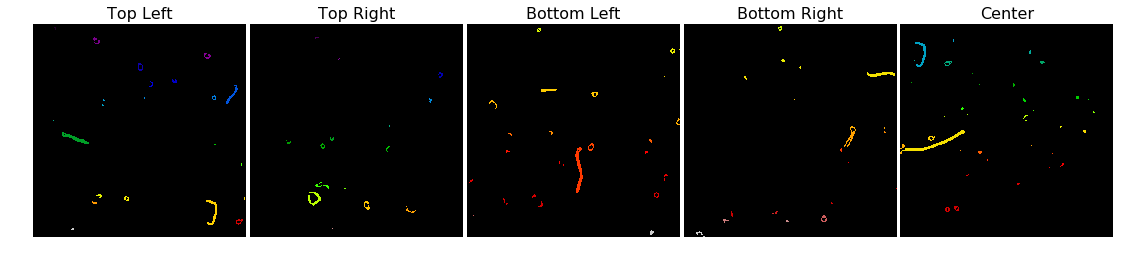

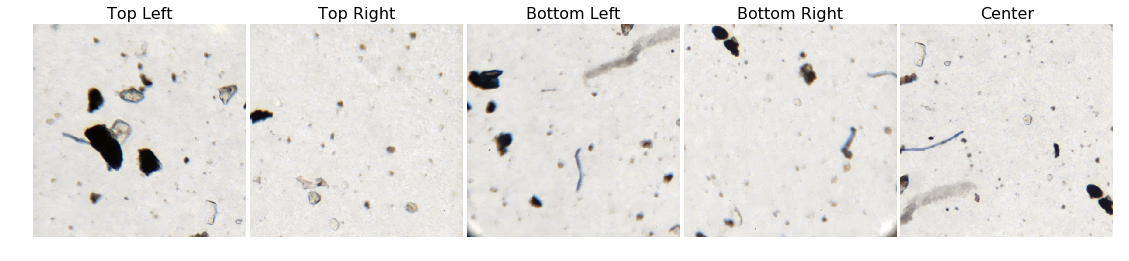

In [11]:
colorfilt = colorfilt1 * colorfilt2 * colorfilt3  # if changed, change in frangi_analysis script.
img = ndimage.label(colorfilt)[0]
if plot is True: pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
img = image
if plot is True: pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## Filter based on Neighborhood Colors
Neighborhood Filter

--DOC--
**DOC**

In [13]:
#########################################################################################
neighborhood_args = {'max_diff'          : 0.1,    # max difference between left and right, or upper and lower sides of an object. [0,1] because images converted to float (-1, 1) scale.
                     'gap'               : 4,      # distance (in pixels) between object and neighborhood
                     'neighborhod_depth' : 4,      # width of 'neighborhood' region.
                     'colorspace'        : 'rgb',  # colorspace to convert to (for RGB images)
                     'band'              : 2       # band of colorspace (for RGB images)
                    }  # True = selecting objects I don't want to keep. 
# neighborhood_args = None

run_on = thresh
# run_on = morph_filt
#########################################################################################

t = pr.neighborhood_filter(image, run_on, max_diff=0.1, gap=4, neighborhood_depth=4, colorspace='rgb', band=2)

NameError: name 'img_split' is not defined

## 8. Filtering based on morphology
This filter removes objects based on the properties of the convex hull, and also of ellipses that have equivalent second moments to the convex hull. The properties are:
* eccentricity: of an ellipse with equivalent moments to the object's convex hull. Should be very high, since hyphae are mostly long and skinny.
* solidity: Percentage of convex hull's area that an object take up. Should be low, since hyphae are curvy and skinny. 
* major axis length: of ellipse with equivalent moments to convex hull. 
* area: in pixels of each object.

Eccentricity and solidity are combined into levels of filters:
1. A 'strict' filter, with stringent eccentricity and solidity thresholds. True objects must pass one.
2. A 'loose' filter, which sets a maximum stringency and minimum eccentricity. True objects must pass both. 

Set the values to allow leeway. Stricter values will be set later in the process. It is helpful to run it on the thresholded image, rather than the color-filter image, to see how tolerances are important. See <a href="https://github.com/pme1123/pyroots/blob/master/pyroots/geometry_filters.py"> documentation</a>.

Long, skinny, but hollow objects will be removed with the next filter. 

/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


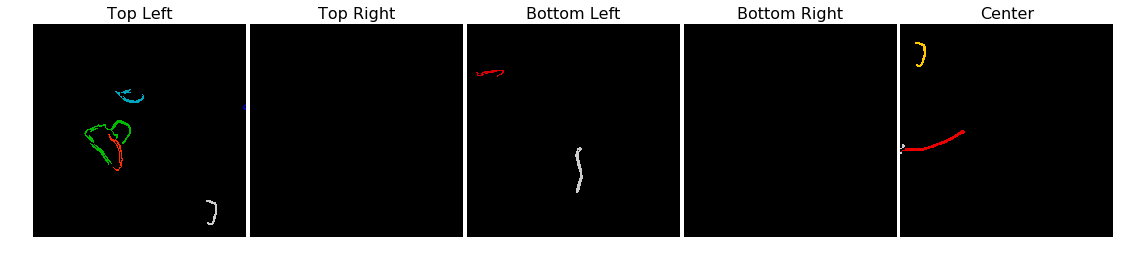

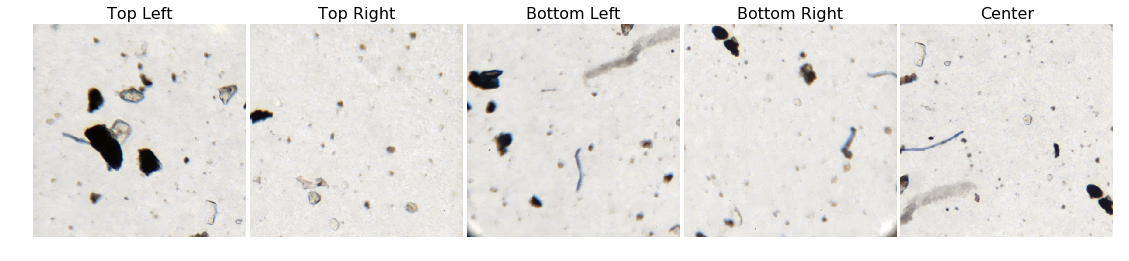

In [9]:
#########################################################################################
morphology_args_1 = {'loose_eccentricity'  : 0.4,   # This is a floor.
                   'loose_solidity'      : 0.6,   # This is a ceiling.
                   'strict_eccentricity' : 0.97,  # Floor.
                   'strict_solidity'     : 0.4,   # Ceiling.
                   'min_length'          : 100,    # Floor.
                   'min_size'            : 100}   # Floor.
run_on = thresh  # uncomment to run on the raw objects from the frangi enhancement
# run_on = colorfilt  # uncomment to run on the objects filtered by color
#########################################################################################

morph_filt = pr.morphology_filter(run_on, **morphology_args_1)

if plot is True:
    img = ndimage.label(morph_filt)[0]
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
    img = image
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## 9. Filter by hollowness
Some objects are long and skinny and have the right color as true objects, but are not. These include really wide objects that were picked up as edges, clear objects with strong parallel edges, etc. They show up as hollow in binary images, and as a result, can be filtered by the ratio of A to B, where:
* A = the medial axis length of the candidate object, similar to the perimeter
* B = the medial axis length of the candidate object after filling the open gaps
This is a slower function, and so should be performed last in the filtering chain. It uses `skimage.morphology.binary_closing` to fill holes, which is more tolerant to long, skinny holes than `remove_small_holes`. See <a href="https://github.com/pme1123/pyroots/blob/master/pyroots/geometry_filters.py"> documentation</a>.

Parameters:
* fill_kernel : Dictates how wide of a gap can be filled. True objects can have loops, but usually they are large compared to edges of larger objects. A value of 15 (default) fills spaces up to 30 pixels wide. 
* threshold : maximum perimiter:filled axis ratio. Solid hyphae should have a ratio close to 1; parallel edges a ratio close to 2. 

Again, it is helpful to set this on a non-filtered, over- and under-thresholded binary image of candidate objects to set appropriate parameters. The ratio is probably larger than expected, due to some small noise loops being present on some objects (which we will take care of next).

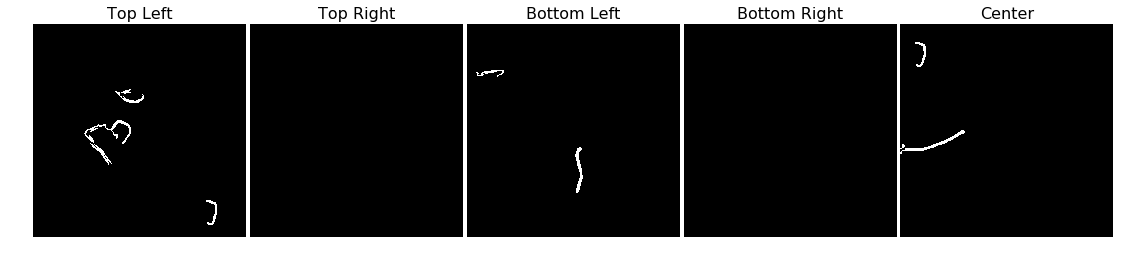

/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


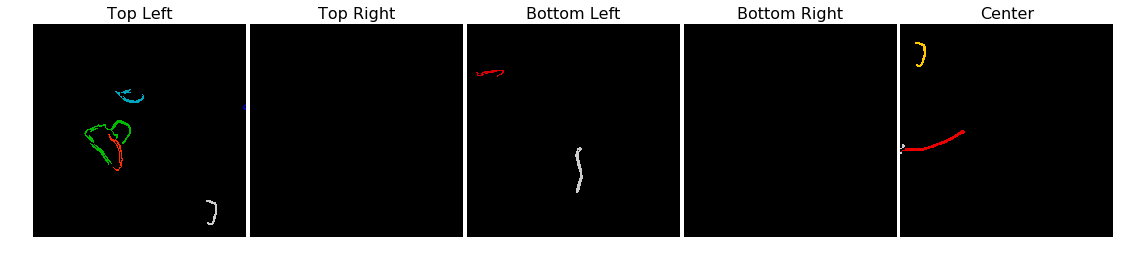

In [10]:
#########################################################################################
hollow_args = {'ratio'       : 1.5,  # this is a ceiling
               'fill_kernel' : 18}   # radius of disk, in pixels, passed to binary_closing
# run_on = thresh      # uncomment to run on the raw objects from the frangi enhancement
# run_on = colorfilt   # uncomment to run on the objects filtered by color
run_on = morph_filt  # uncomment to run on the objects filtered by morphology.
#########################################################################################

try:
    run_on = morphology.remove_small_holes(run_on, min_size=10)
    hollow_filt = pr.hollow_filter(run_on, **hollow_args)
    if plot is True:
        img = hollow_filt
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
        img = ndimage.label(morph_filt)[0]
        pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map = "spectral")
#         img = [run_on, hollow_filt, image]
#         pr.multi_image_plot(img, ['objects', 'filtered', 'image'])
except:
    print("Nothing to Filter")
    hollow_filt = np.ones(thresh.shape)

## 10. Combine Filters and Check Results.
Generally, only keep objects that pass all three filter sets. Did you keep (almost all) of what you wanted, and nothing else? 
* **If so**: Continue
* **If not**: Are the objects you want to ignore close together and parallel? Are they extremely thin? If so, a diameter filter after filling gaps might be helpful. Otherwise, try changing thresholding offsets or frangi sensitivity first. Pay special attention to connectivity of candidate objects in the initial thresholding image.

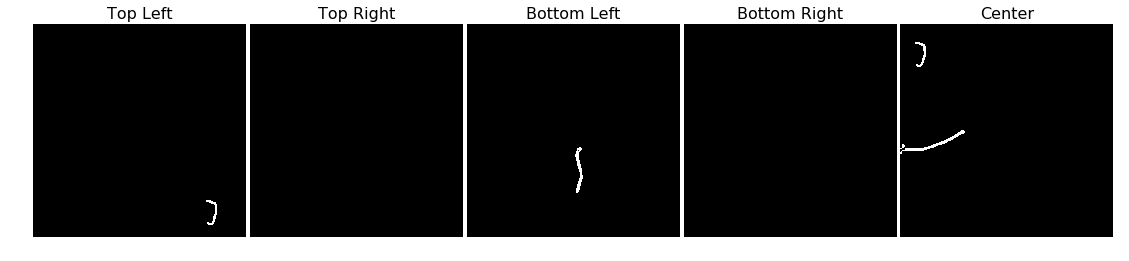

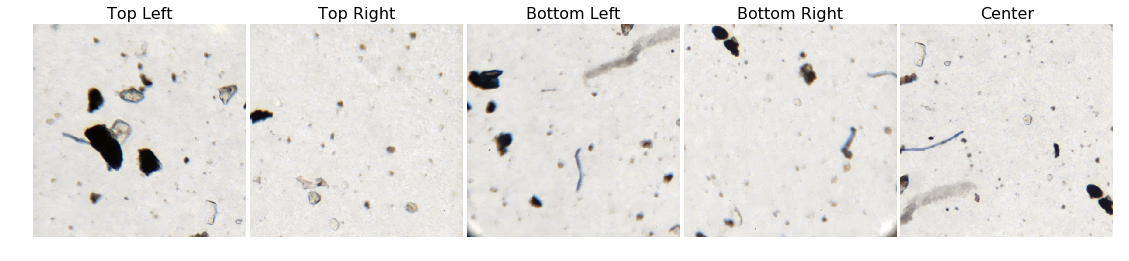

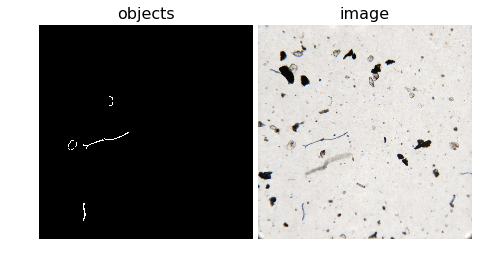

In [11]:
filt = colorfilt * morph_filt * hollow_filt

if plot is True:
    img = filt
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
    img = image
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
    img = [filt, image]
    pr.multi_image_plot(img, ['objects', 'image'])

## 11. Fill small holes and close small gaps in true objects
This step closes small gaps and holes. The gaps underestimate true object length; the holes lead to overestimation. Filling these gaps allows for more stringent geometry filtering; doing this after most filtering reduces real objects from sticking to spurrious objects. Pick parameters that allow most gaps to be filled consistently without joining truely discrete objects too often.

Hole filling and gap closing uses `skimage.morphology.binary_closing`, which preserves edge width. `min_size` is used for `skimage.morphology.remove_small_holes` after closing the image, and represents a floor area in pixels that is considered to be a true gap or hole in the object, such as when roots/hyphae cross and loop. The call to the median filter is optional but reduces small burrs that throw off the medial axis algorithm. <a href="http://scikit-image.org/docs/dev/api/skimage.filters.html"> Documentation</a>.

CM1-0039.png


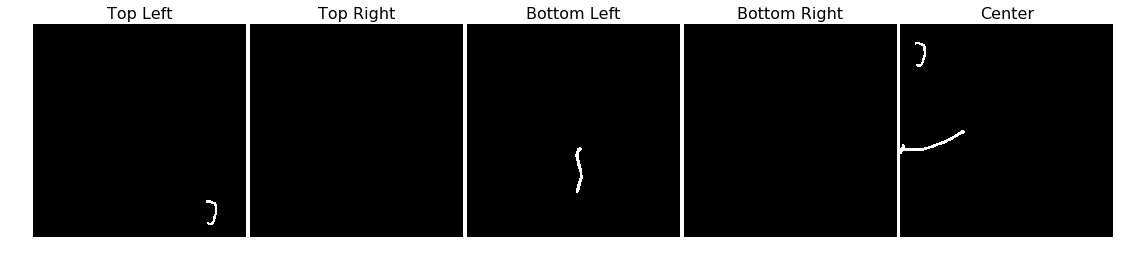

In [12]:
#########################################################################################
fill_gaps_args = {'closing_radius'  : 8,  # radius of 8 pixels; fills up to 32 px wide spaces
                  'min_hole_size'      : 300,                 # area in pixels.
                  'median_radius'   : 1.6}  # manhattan connectivity = 1. 
#########################################################################################
holes_filled = pr.fill_gaps(filt, **fill_gaps_args)

print(file_in[selection])
if plot is True:
    img = holes_filled
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)

## Perform a final morphological filtering, this time more stringent
Because faint objects should be better connected, morphological filtering can be more stringent now.

At the point, the only spurrious objects remaining should be far wider or narrower than your target objects. 

/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


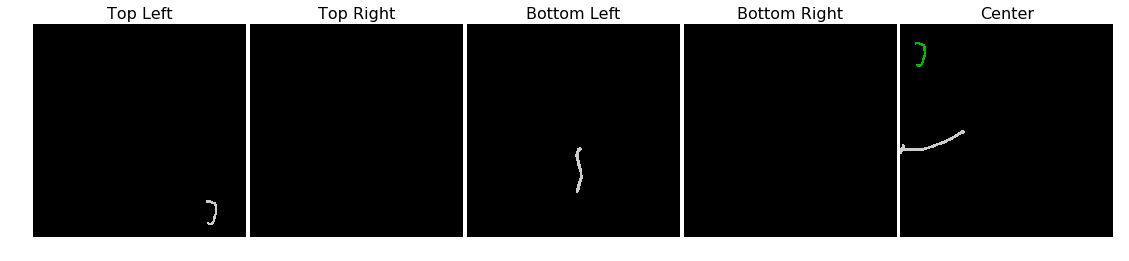

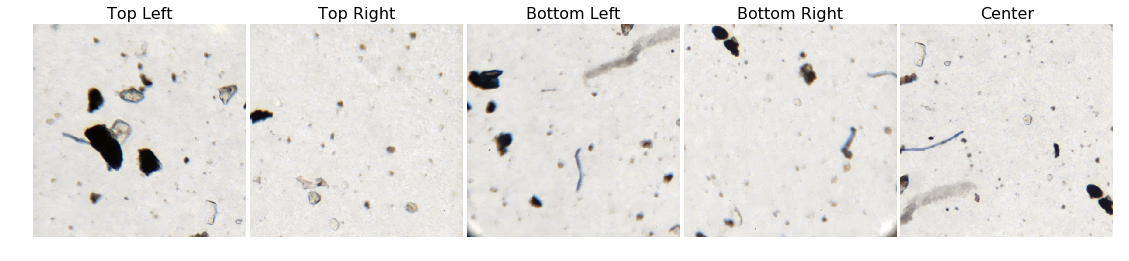

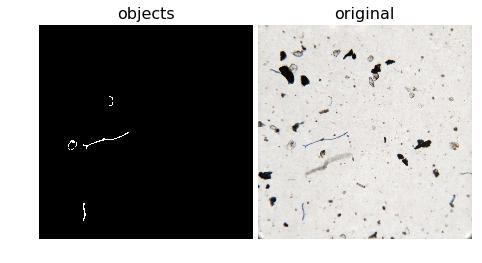

In [14]:
#########################################################################################
morphology_args_2 = {'loose_eccentricity'  : 0.5,   # This is a floor.
                   'loose_solidity'      : 0.5,   # This is a ceiling.
                   'strict_eccentricity' : 0.97,  # Floor.
                   'strict_solidity'     : 0.4,   # Ceiling.
                   'min_length'          : 125,    # Floor.
                   'min_size'            : 125}   # Floor.
morphology_args_2 = 'skip'
#########################################################################################

if morphology_args_2 is 'skip':
    morph_filt_2 = holes_filled.copy()
else:
    morph_filt_2 = pr.morphology_filter(holes_filled, **morphology_args_2)

if plot is True:
    img = ndimage.label(morph_filt_2)[0]
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names, color_map="spectral")
    img = image
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], zoom_names)
    img = [morph_filt_2, image]
    pr.multi_image_plot(img, ['objects', 'original'])

## 12. Compute skeleton
Perform medial axis skeletonization of the image, and calculate the lenth of each ixelin that image. See <a href="https://github.com/pme1123/pyroots/blob/master/pyroots/skeletonization.py"> documentation</a>.
This function returns a dictionary with keys:
- `"geometry"` - Length and diameter of each object, including background
- `"objects"` - binary immage
- `"diameter"` - array with medial axis diameter shown by color.
- `"length"` - array with medial axis length at each pixel shown by color

    Diameter   Length
0   0.000000    0.000
1   7.982581  117.451
2  10.217456  421.386
3   8.050008  230.120
4  10.574203  144.385


/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


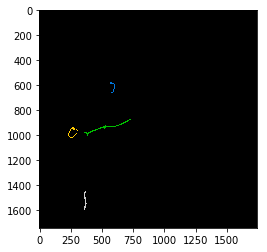

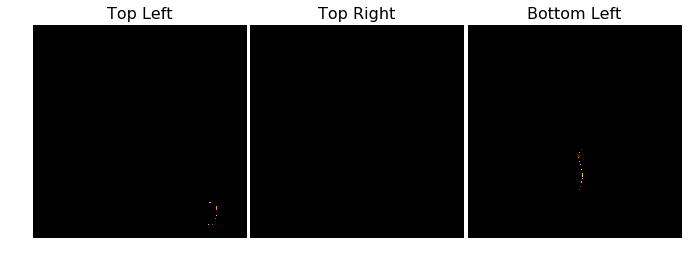

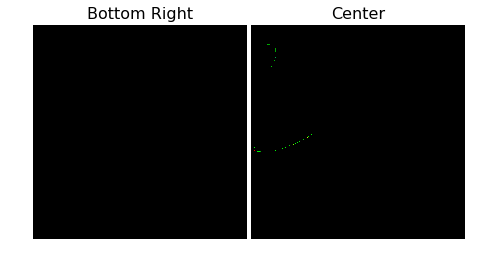

In [17]:
#############################################################
# Nothing to change here
#############################################################

skel = pr.skeleton_with_distance(morph_filt_2)

if plot is True:
    print(skel['geometry'])
    img = ndimage.label(skel['objects'])[0]
    plt.imshow(img, cmap="spectral")
    img = skel['diameter']
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[0:3]], zoom_names[0:3], color_map = "spectral")
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[3:5]], zoom_names[3:5], color_map = "spectral")

# Filter by Mean Diameter

Remove objects that are narrower than a given threshold (on average), or wider than a given threshold (on average).

Uses `pyroots.diameter_filter`.

    Diameter   Length
0   0.000000    0.000
1   7.982581  117.451
2  10.217456  421.386
3   8.050008  230.120
4  10.574203  144.385


/home/patrick/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


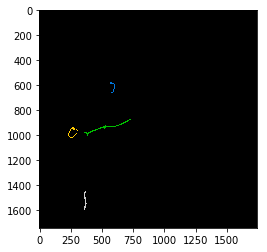

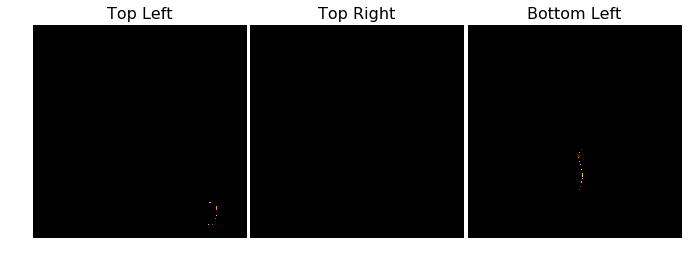

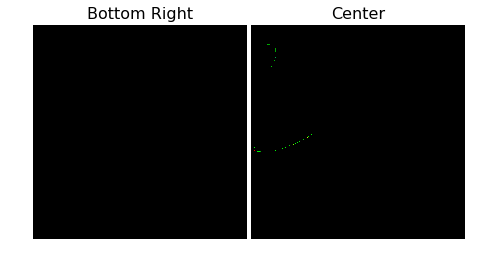

In [18]:
################################################################
diameter_args = {'max_diameter'   : 12,
                 'min_diameter'   : 4.5,
                 'max_percentile' : 70,      # xx percent must not be larger than max_diameter
                 'min_percentile' : 50,      # xx percent must not be smaller than min_diameter
                 'pixel_level'    : False}    # remove individual pixels that don't meet max/min requirements?
################################################################

diam = pr.diameter_filter(skel, **diameter_args)

if plot is True:
    print(diam['geometry'])
    img = ndimage.label(diam['objects'])[0]
    plt.imshow(img, cmap="spectral")
    img = diam['diameter']
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[0:3]], zoom_names[0:3], color_map = "spectral")
    pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list[3:5]], zoom_names[3:5], color_map = "spectral")

## 13. Summarize
Summarize the objects in the image. Options center around:
- Binning pixels by diameter class
- Aggregating all objects.

Diameter class is approximate in this case, due to the frangi filter response being correlated with object width, but also strongly related to object visibility. For more accurate diameters, try the thresholding approach of `pyroots_analysis`. 

In [19]:
################################################################
diameter_bins = None
image_name = "image"
################################################################

if diameter_bins is None:
    summary_df = pr.summarize_geometry(diam['geometry'], image_name)

else:
    diam_out, summary_df = pr.bin_by_diameter(diam_dict['length'],
                                              diam_dict['diameter'],
                                              diameter_bins,
                                              image_name)

if plot is True: print(summary_df)

  ImageName   Length  NObjects  MeanDiam
0     image  913.342         4  9.440362


## 14. Save the parameters for later use

In [21]:
################################################################
settings_path = dir_in
settings_name = 'temp_segmentation.py'  # arbitrary extension for clarity
write = True                               # automatically update items as changed? 
write = False
################################################################

dicts = ['colors', 'frangi_args', 'threshold_args', 
         'color_args_1', 'color_args_2', 'color_args_3', 'morphology_args_1', 
         'morphology_args_2', 
         'hollow_args', 
         'fill_gaps_args', 'diameter_args', 
         'diameter_bins']

if write is True:
    path_out = os.path.join(settings_path, settings_name)
    print("Wrote to: {}".format(path_out))
    with open(path_out, 'w') as file:
        for i in dicts:
            print(i + " = " + str(locals()[i]), file=file)

for i in dicts:
    print(i + " = " + str(locals()[i]))

colors = {'colorspace': 'rgb', 'band': 0, 'invert': False}
frangi_args = {'black_ridges': True, 'beta1': 0.99, 'scale_range': (2, 6), 'beta2': 0.03, 'scale_step': 1}
threshold_args = {'block_size': 31, 'offset': 0.21}
color_args_1 = {'colorspace': 'rgb', 'target_band': 2, 'high': 0.99, 'invert': False, 'percent': 55, 'low': 0.6}
color_args_2 = {'colorspace': 'hsv', 'target_band': 1, 'high': 1, 'invert': True, 'percent': 30, 'low': 0.5}
color_args_3 = {'colorspace': 'hsv', 'target_band': 0, 'high': 0.69, 'invert': False, 'percent': 40, 'low': 0.45}
morphology_args_1 = {'strict_solidity': 0.4, 'loose_solidity': 0.6, 'loose_eccentricity': 0.4, 'strict_eccentricity': 0.97, 'min_length': 100, 'min_size': 100}
morphology_args_2 = skip
hollow_args = {'ratio': 1.5, 'fill_kernel': 18}
fill_gaps_args = {'closing_radius': 8, 'median_radius': 1.6, 'min_hole_size': 300}
diameter_args = {'max_diameter': 12, 'min_percentile': 50, 'pixel_level': False, 'min_diameter': 4.5, 'max_percentile': 70}
diamet

# Run on all images
To run this as a batch, either use the cell below with the image loop (make sure all dictionaries above are loaded into the environment) or run in the terminal. The latter option might be better for lots of threads (i.e. supercomputers). If running in this notebook, check your resource usage first and ensure you have enough RAM (~50 MB/thread for a 7MB image).

## Option 1: Run In Notebook
First, make sure the full function behaves. Then set up the loop.

/usr/lib/python3/dist-packages/pyroots/frangi_segmentation.py:140: UserWarning: Skipping hollow filter
  warn("Skipping hollow filter")


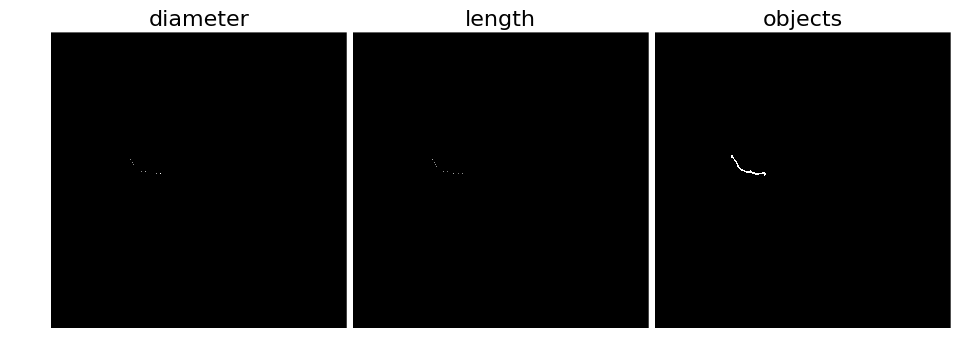

  ImageName   Length  NObjects  MeanDiam
0     image  263.429         1  9.545729


In [28]:
##############################################################
test = True
# test=False
##############################################################
if test is True:    
    test_out = pr.frangi_segmentation(image, colors, frangi_args, threshold_args,
                                      color_args_1, color_args_2, color_args_3,
                                      morphology_args_1, morphology_args_2, "hollow_args", fill_gaps_args, 
                                      diameter_args, diameter_bins, image_name="image")

    img = ['diameter', 'length', 'objects']
    pr.multi_image_plot([test_out[i] for i in img], img)
    print(test_out['geometry'])

In [ ]:
import pyroots as pr
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")
update_dirs = True
# update_dirs = False
if update_dirs == True:
    dir_in = "/home/patrick/Documents/HLD Pictures Feb 2017/image filtered/02-06-2017/Processed_No_Smoothing"
    settings_path = dir_in
    settings_name = 'segmentation_settings_nosmooth_02-22-2017.py'  # arbitrary extension for clarity



x = pr.frangi_image_loop(dir_in,
                         dir_out=os.path.join(dir_in, "02-22_settings"),
                         extension_in=".png", 
                         table_out=os.path.join(dir_in, "NewParameters_2-22", "output.txt"),
                         params=os.path.join(settings_path, settings_name),
                         save_images=True,
                         table_overwrite=False,
                         threads=4)

The parameters you've loaded are:

colors = {'invert': False, 'colorspace': 'rgb', 'band': 0}


frangi_args = {'scale_range': (2, 6), 'beta2': 0.03, 'black_ridges': True, 'scale_step': 1, 'beta1': 0.99}


threshold_args = {'offset': 0.21, 'block_size': 31}


color_args_1 = {'invert': False, 'target_band': 2, 'percent': 55, 'high': 0.99, 'low': 0.6, 'colorspace': 'rgb'}


color_args_2 = {'invert': True, 'target_band': 1, 'percent': 30, 'high': 1, 'low': 0.5, 'colorspace': 'hsv'}


color_args_3 = {'invert': False, 'target_band': 0, 'percent': 40, 'high': 0.69, 'low': 0.45, 'colorspace': 'hsv'}


morphology_args_1 = {'loose_eccentricity': 0.4, 'strict_eccentricity': 0.97, 'min_length': 100, 'loose_solidity': 0.6, 'min_size': 100, 'strict_solidity': 0.4}


morphology_args_2 = {'loose_eccentricity': 0.5, 'strict_eccentricity': 0.97, 'min_length': 125, 'loose_solidity': 0.5, 'min_size': 125, 'strict_solidity': 0.4}


hollow_args = None


fill_gaps_args = {'min_hole_size': 300, 'closing_struc

  0%|          | 0/8156 [00:00<?, ?it/s]


ALREADY ANALYZED: AU2-0116.png. Skipping...

ALREADY ANALYZED: AZ2-1081.png. Skipping...

ALREADY ANALYZED: BF2-2149.png. Skipping...

ALREADY ANALYZED: BB1-1359.png. Skipping...





ALREADY ANALYZED: BD2-1753.png. Skipping...

ALREADY ANALYZED: BB1-1376.png. Skipping...

ALREADY ANALYZED: BC2-1646.png. Skipping...

ALREADY ANALYZED: BA1-1120.png. Skipping...





ALREADY ANALYZED: AZ1-1044.png. Skipping...

ALREADY ANALYZED: BB1-1293.png. Skipping...

ALREADY ANALYZED: BA2-1252.png. Skipping...

ALREADY ANALYZED: BF1-2039.png. Skipping...





ALREADY ANALYZED: AW2-0578.png. Skipping...

ALREADY ANALYZED: BE2-1933.png. Skipping...

ALREADY ANALYZED: AW2-0520.png. Skipping...

ALREADY ANALYZED: BB2-1388.png. Skipping...





ALREADY ANALYZED: BD1-1740.png. Skipping...

ALREADY ANALYZED: BF2-2128.png. Skipping...

ALREADY ANALYZED: AU2-0203.png. Skipping...




ALREADY ANALYZED: AU1-0070.png. Skipping...

ALREADY ANALYZED: BB2-1448.png. Skipping...




  0%|          | 22/8156 [00:14<1:32:18,  1.47it/s]

Done: BA1-1113.png

ALREADY ANALYZED: AY2-0961.png. Skipping...



  0%|          | 24/8156 [00:15<1:11:12,  1.90it/s]

Done: AV2-0370.png


  0%|          | 25/8156 [00:18<2:46:34,  1.23s/it]

Done: AX2-0720.png


  0%|          | 26/8156 [00:22<4:59:01,  2.21s/it]

Done: AX2-0735.png


  0%|          | 27/8156 [00:31<9:32:57,  4.23s/it]

Done: AU1-0093.png

ALREADY ANALYZED: AX2-0769.png. Skipping...



  0%|          | 29/8156 [00:36<8:24:08,  3.72s/it]

Done: AY2-0876.png


  0%|          | 30/8156 [00:39<7:56:15,  3.52s/it]

Done: BB2-1399.png


  0%|          | 31/8156 [00:44<8:55:48,  3.96s/it]

Done: AY1-0786.png


  0%|          | 32/8156 [00:48<8:41:28,  3.85s/it]

Done: BF2-2184.png

ALREADY ANALYZED: BB2-1405.png. Skipping...



  0%|          | 34/8156 [00:59<9:53:27,  4.38s/it]

Done: BB1-1321.png


  0%|          | 36/8156 [00:59<7:02:45,  3.12s/it]

Done: BB1-1297.png


  0%|          | 37/8156 [01:03<7:15:18,  3.22s/it]

Done: BF2-2108.png


  0%|          | 38/8156 [01:11<10:36:57,  4.71s/it]

Done: AZ1-0985.png


  0%|          | 39/8156 [01:17<11:23:27,  5.05s/it]

Done: AY1-0836.png


  0%|          | 40/8156 [01:22<11:32:13,  5.12s/it]

Done: AW1-0456.png


  1%|          | 41/8156 [01:22<8:16:45,  3.67s/it] 

Done: BF2-2192.png


  1%|          | 42/8156 [01:30<11:04:40,  4.92s/it]

Done: BB1-1326.png


  1%|          | 43/8156 [01:35<11:10:25,  4.96s/it]

Done: AW2-0580.png


  1%|          | 44/8156 [01:41<11:26:05,  5.07s/it]

Done: AX1-0678.png
Done: AY2-0892.png


  1%|          | 46/8156 [01:48<10:36:10,  4.71s/it]

Done: BE2-1986.png


  1%|          | 47/8156 [01:57<13:02:54,  5.79s/it]

Done: AU1-0084.png


  1%|          | 48/8156 [01:57<9:17:20,  4.12s/it] 

Done: BC2-1573.png


  1%|          | 49/8156 [02:01<8:56:53,  3.97s/it]

Done: AX2-0762.png


  1%|          | 50/8156 [02:06<9:53:05,  4.39s/it]

Done: AV1-0283.png


  1%|          | 52/8156 [02:15<9:19:22,  4.14s/it] 

Done: AU2-0152.png
Done: AV2-0379.png


  1%|          | 53/8156 [02:26<13:35:18,  6.04s/it]

Done: AX2-0738.png


  1%|          | 54/8156 [02:26<9:39:29,  4.29s/it] 

Done: BA2-1234.png


  1%|          | 55/8156 [02:31<10:25:07,  4.63s/it]

Done: AX1-0666.png


  1%|          | 56/8156 [02:38<11:23:09,  5.06s/it]

Done: AY1-0784.png


  1%|          | 57/8156 [02:44<12:03:15,  5.36s/it]

Done: AU1-0047.png


  1%|          | 58/8156 [02:48<11:22:00,  5.05s/it]

Done: AV2-0373.png


  1%|          | 59/8156 [02:52<10:25:19,  4.63s/it]

Done: AV2-0374.png


In [3]:
print(dir_in)

/home/patrick/Documents/HLD Pictures Feb 2017/image filtered/02-06-2017/Processed_No_Smoothing
